In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# number of nodes in hidden layer
N_HIDDEN = [25, 10]
# number of mixtures
K_MIX = 10
# samples to learn from
N_SAMPLE = 3000

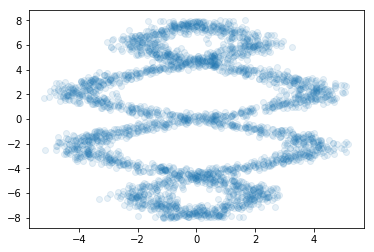

In [40]:
def build_toy_dataset1(N=N_SAMPLE):
    y_data = np.random.uniform(-5, 5, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    return x_data.reshape((N, 1)), y_data.reshape((N, 1))

def build_toy_dataset2(N=N_SAMPLE):
    y_data = np.random.uniform(-8, 8, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data * (0.5 + np.random.randint(-1, 1, N))
    return x_data.reshape((N, 1)), y_data.reshape((N, 1))

def build_toy_dataset3(N=N_SAMPLE):
    data1 = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0.5],[0.5,1]]), size=int(N/3))
    data2 = np.random.multivariate_normal(np.array([4,4]), np.array([[1,-0.5],[-0.5,1]]), size=int(N/3))
    data3 = np.random.multivariate_normal(np.array([-2,6]), np.array([[0.5,-0.1],[-0.1,0.5]]), size=int(N/3))
    data = np.concatenate([data1, data2, data3])
    return data[:,0].reshape((N, 1)), data[:,1].reshape((N, 1))

def build_toy_dataset4(N=N_SAMPLE):
    x_data = np.linspace(-15, 15, N)
    y_data = np.sin(x_data) + x_data**2/200 + np.random.normal(0, np.abs(np.sin(x_data))/3, N)
    return x_data.reshape((N, 1)), y_data.reshape((N, 1))

x_data, y_data = build_toy_dataset2()
data = np.concatenate([x_data.T, y_data.T]).T
plt.scatter(x_data, y_data, alpha=0.1)

Now to build the neural network!

In [41]:
x_ph = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_ph = tf.placeholder(shape=[None, 1], dtype=tf.float32)

nn = tf.contrib.slim.fully_connected(x_ph, N_HIDDEN[0], activation_fn= tf.nn.relu)
for nodes in N_HIDDEN[1:]:
    nn = tf.contrib.slim.fully_connected(nn, nodes, activation_fn=tf.nn.tanh,
                                        weights_regularizer=tf.contrib.slim.regularizers.l2_regularizer(scale=0.1))

mu_nodes = tf.contrib.slim.fully_connected(nn, K_MIX, activation_fn=None)
sigma_nodes = tf.contrib.slim.fully_connected(nn, K_MIX, activation_fn=tf.exp, 
                                              weights_regularizer=tf.contrib.slim.regularizers.l2_regularizer(scale=0.1))
pi_nodes = tf.contrib.slim.fully_connected(nn, K_MIX, activation_fn=tf.nn.softmax)

norm = (y_ph - mu_nodes)/sigma_nodes
pdf = tf.exp(-tf.square(norm))/2/sigma_nodes
likelihood = tf.reduce_sum(pdf*pi_nodes, axis=1)
log_lik = tf.reduce_sum(tf.log(likelihood))

optimizer = tf.train.RMSPropOptimizer(0.01).minimize(-log_lik)

init = tf.global_variables_initializer()

To sample from a gaussian mixture we need to be careful. First sample which gaussian. Then sample the correct one.

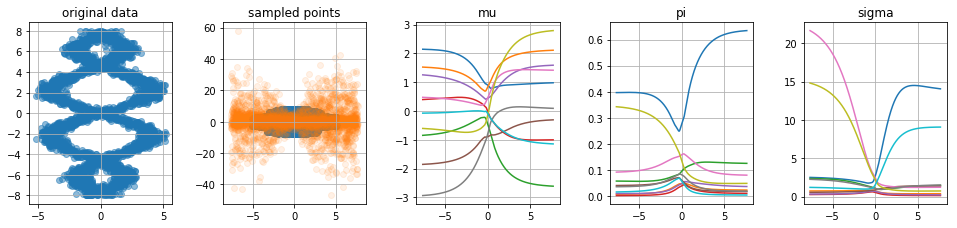

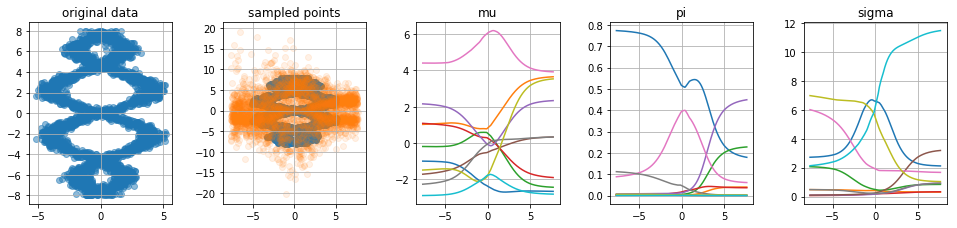

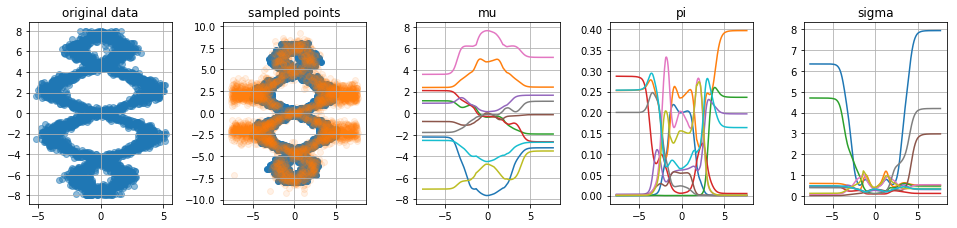

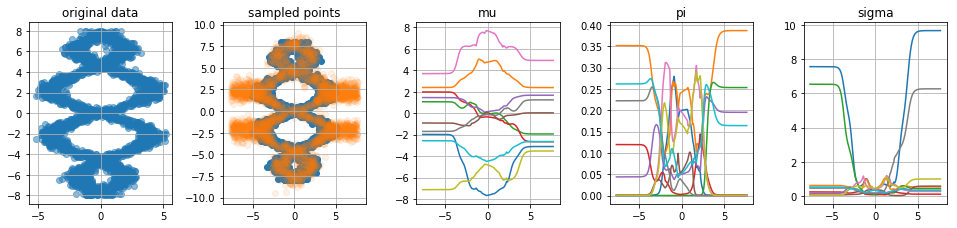

In [81]:
with tf.Session() as sess:
    sess.run(init)
    for step in range(10001):
        _, val = sess.run([optimizer, log_lik], feed_dict={x_ph: x_data, y_ph: y_data})
        if step in [10, 100, 2000, 5000, 50000]:
            x_test = np.linspace(x_data.min()-2.5, x_data.max()+2.5, 3000).reshape((3000, 1))
#             x_test = np.ones(shape=(10000,1)) * 3
            mu, sigma, pi = sess.run([mu_nodes, sigma_nodes, pi_nodes], feed_dict={x_ph: x_test})
            plt.figure(1, figsize=(15,3))
            plt.subplot(151)
            plt.scatter(x_data, y_data, alpha=0.5)
            plt.title("original data")
            plt.grid(True)
            plt.subplot(152)
            plt.scatter(x_data, y_data)
            y_test = []
            for i,x in enumerate(x_test):
                sample_pi = np.random.choice(np.arange(pi.shape[1]), size=1, p=pi[i])
                sample_point = np.random.normal(mu[i, sample_pi], sigma[i, sample_pi])
                y_test.append(float(sample_point))
            plt.scatter(x_test, y_test, alpha=0.1)
            plt.title("sampled points".format(step, val))
            plt.grid(True)
            
            plt.subplot(153)
            for i in range(mu.shape[1]):
                plt.plot(x_test, mu[:, i])
                plt.title("mu")
            plt.grid(True) 
            
            plt.subplot(154)
            for i in range(pi.shape[1]):
                plt.plot(x_test, pi[:, i])
                plt.title("pi")
            plt.grid(True)
            
            plt.subplot(155)
            for i in range(sigma.shape[1]):
                plt.plot(x_test, sigma[:, i])
                plt.title("sigma")
            plt.grid(True) 
            plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
            plt.show()

### Mixture Models

But now without the deep neuron jazz.

In [72]:
from sklearn import mixture
from matplotlib.colors import LogNorm

clf = mixture.GaussianMixture(n_components=40, covariance_type='full')
clf.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=40, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [73]:
x = np.linspace(data[:,0].min() - 0.5, data[:,0].max() + 0.5)
y = np.linspace(data[:,1].min() - 0.5, data[:,1].max() + 0.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

Text(0.5,1,'DATASET: neg loglik and original samples')

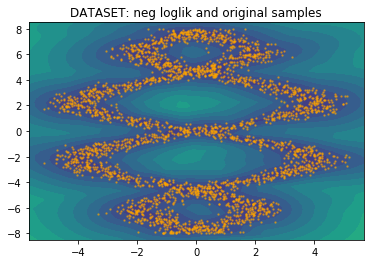

In [74]:
CS = plt.contourf(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 20))
plt.scatter(data[:, 0], data[:, 1], 2, c="orange", alpha=0.5)
plt.title("DATASET: neg loglik and original samples")

Text(0.5,1,'NEURAL GMM')

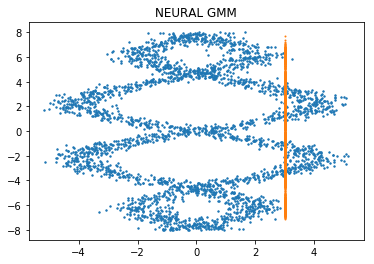

In [75]:
plt.scatter(data[:, 0], data[:, 1], 2)
plt.scatter(x_test, y_test, 1)
plt.title('NEURAL GMM')

In [76]:
import scipy.stats as stats

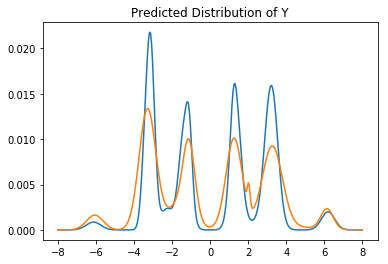

In [79]:
x = 3
ys = np.linspace(-8, 8, 300)

gmm_lik = np.exp(clf.score_samples([[x, i] for i in ys]))
mdm_lik = np.mean([stats.norm(m, s).pdf(ys)*p for m, s, p in zip(mu[0], sigma[0], pi[0])], axis=0)
plt.plot(ys, gmm_lik/gmm_lik.sum())
plt.plot(ys, mdm_lik/mdm_lik.sum())
plt.title('Predicted Distribution of Y');

Text(0.5,1,'Original Dataset with X-val')

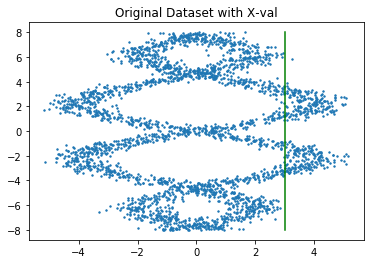

In [80]:
plt.scatter(data[:, 0], data[:, 1], 2)
plt.plot(np.ones(ys.shape) * x, ys, c="green")
plt.title('Original Dataset with X-val')

So sometimes the mixture model is good enough but it does need tuning. It seems like the neural network is pretty good at tuning, bit it has an issue with areas where it has not seen any data. Because $\sum \pi(x) = 1$ we are always able to generate data in regions where there really should not be any. We could append this by forcing that $\sum \pi(x) = 0$ if there is no data. This can be done, but it feels like a lot of hacking and we'd still end up with a model that is limited.